<a href="https://colab.research.google.com/github/jh-4166640/Machine-Learning-Lecture/blob/main/FinancePredictModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----
#주가 예측 텀프로젝트
-----

###Train / Test divied

In [109]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdrhrk

# data load
# shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01') # 신풍제약의 작은 폭의 잦은 등락으로 상승 추세선의 2015 부근이라  2014-12부터 선택
# robostar_finance = yf.download('090360.KQ', start='2013-09-01')        # 로보스타의 작은 하락 추세선을 학습에 사용하기 위함
# daihan_pharm_finance = yf.download('023910.KQ', start='2010-09-01')    # 급등 전의 신호가 있는 위치가 2010-09
# dbhitek_finance = yf.download('000990.KS', start='2009-05-01')         # 등락 변동성이 가장 큰 부분부터 시작하기 위함
# skdnd_finance = yf.download('210980.KS', start='2016-05-01')           # 상장 후 안정기에 진입했을 때부터 학습

shinpoong_pharm_finance = yf.download('019170.KS', start='2022-05-01') # 주가가 큰 변동이 없을 때
robostar_finance = yf.download('090360.KQ', start='2024-04-01')        # 변동성이 가장 큰 주식으로 이상치 데이터로 사용하기 위함
daihan_pharm_finance = yf.download('023910.KQ', start='2021-09-01')    # 큰 변동성이 최대한 없는 부분부터
dbhitek_finance = yf.download('000990.KS', start='2022-07-01')         # 상승하는 부분부터 사용하기 위해서
skdnd_finance = yf.download('210980.KS', start='2024-04-01')           # 너무 큰 급락 폭을무시하기 위해서

# train, test divied
shinpoong_train_idx = np.where('2025-10-20'>shinpoong_pharm_finance.index)
robostar_train_idx = np.where('2025-10-20'>robostar_finance.index)
daihan_train_idx = np.where('2025-10-20'>daihan_pharm_finance.index)
dbhitek_train_idx = np.where('2025-10-20'>dbhitek_finance.index)
skdnd_train_idx = np.where('2025-10-20'>skdnd_finance.index)

shinpoong_test_idx = np.where('2025-10-20'<=shinpoong_pharm_finance.index)
robostar_test_idx = np.where('2025-10-20'<=robostar_finance.index)
daihan_test_idx = np.where('2025-10-20'<=daihan_pharm_finance.index)
dbhitek_test_idx = np.where('2025-10-20'<=dbhitek_finance.index)
skdnd_test_idx = np.where('2025-10-20'<=skdnd_finance.index)

# shinpoong_train = shinpoong_pharm_finance.iloc[shinpoong_train_idx]
# robostar_train = robostar_finance.iloc[robostar_train_idx]
# daihan_train = daihan_pharm_finance.iloc[daihan_train_idx]
# dbhitek_train = dbhitek_finance.iloc[dbhitek_train_idx]
# skdnd_train = skdnd_finance.iloc[skdnd_train_idx]

# shinpoong_test = shinpoong_pharm_finance.iloc[shinpoong_test_idx]
# robostar_test = robostar_finance.iloc[robostar_test_idx]
# daihan_test = daihan_pharm_finance.iloc[daihan_test_idx]
# dbhitek_test = dbhitek_finance.iloc[dbhitek_test_idx]
# skdnd_test = skdnd_finance.iloc[skdnd_test_idx]

/tmp/ipython-input-2861044495.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  shinpoong_pharm_finance = yf.download('019170.KS', start='2022-05-01') # 주가가 큰 변동이 없을 때
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2861044495.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar_finance = yf.download('090360.KQ', start='2024-04-01')        # 변동성이 가장 큰 주식으로 이상치 데이터로 사용하기 위함
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2861044495.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daihan_pharm_finance = yf.download('023910.KQ', start='2021-09-01')    # 큰 변동성이 최대한 없는 부분부터
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2861044495.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dbhitek_finance = yf.download('000990.KS

###기술적 지표 추가

In [110]:

# NaN 제거 - GPT 활용
def clean_nan(data, method="drop"):
    """
    data: pandas DataFrame
    method: 'drop', 'bfill', 'ffill', 'bothfill'
    """
    if method == "drop":
        return data.dropna()

    elif method == "bfill":
        return data.fillna(method="bfill")

    elif method == "ffill":
        return data.fillna(method="ffill")

    elif method == "bothfill":
        return data.fillna(method="ffill").fillna(method="bfill")

    else:
        raise ValueError("method must be: 'drop', 'bfill', 'ffill', 'bothfill'")


# 단순 이동평균선 데이터 + 불린저 밴드 사용
def BollingerBand(data, window=9):
  # SMA20
  data[f'BB_MID_{window}'] = data['Close'].rolling(window=window).mean()
  # 표준편차
  data[f'BB_STD_{window}'] = data['Close'].rolling(window=window).std()
  # 상단 밴드
  data[f'BB_UPPER_{window}'] = data[f'BB_MID_{window}'] + (2 * data[f'BB_STD_{window}'])
  # 하단 밴드
  data[f'BB_LOWER_{window}'] = data[f'BB_MID_{window}'] - (2 * data[f'BB_STD_{window}'])

  return data

# EMA 지수 이동평균선 사용
def ExpMovingAverage(data, windows=[4, 12]):
  for w in windows:
    data[f'EMA{w}'] = data['Close'].ewm(span=w, adjust=False).mean()
  return data

def add_ticker_id(arr, id_num):
  id_col = np.full((arr.shape[0], 1), id_num)
  return np.hstack([arr, id_col])


sp1=BollingerBand(shinpoong_pharm_finance)
rbs1=BollingerBand(robostar_finance)
dh1=BollingerBand(daihan_pharm_finance)
dbh1=BollingerBand(dbhitek_finance)
skd1=BollingerBand(skdnd_finance)

print((sp1.shape))

sp2=ExpMovingAverage(sp1)
rbs2=ExpMovingAverage(rbs1)
dh2=ExpMovingAverage(dh1)
dbh2=ExpMovingAverage(dbh1)
skd2=ExpMovingAverage(skd1)

sp=clean_nan(sp2,"bothfill")
rbs=clean_nan(rbs2,"bothfill")
dh=clean_nan(dh2,"bothfill")
dbh=clean_nan(dbh2,"bothfill")
skd=clean_nan(skd2,"bothfill")

np_sp = sp.values
np_rbs = rbs.values
np_dh = dh.values
np_dbh = dbh.values
np_skd = skd.values
print(np_sp.shape)


np_sp = add_ticker_id(np_sp, 1)
np_rbs = add_ticker_id(np_rbs,2)
np_dh = add_ticker_id(np_dh,3)
np_dbh = add_ticker_id(np_dbh,4)
np_skd = add_ticker_id(np_skd,5)

print(np_sp.shape)



(880, 9)
(880, 11)
(880, 12)


/tmp/ipython-input-1221904741.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method="ffill").fillna(method="bfill")


In [111]:
def minmax_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 min/max 값도 반환
    """
    data_norm = data.copy()
    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    min_vals = {}
    max_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        min_val = col.min()
        max_val = col.max()
        min_vals[idx] = min_val
        max_vals[idx] = max_val

        if max_val - min_val == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - min_val) / (max_val - min_val)

    if return_params:
        return data_norm, min_vals, max_vals
    else:
        return data_norm

def std_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 mean/std 반환
    """
    data_norm = data.copy()

    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    mean_vals = {}
    std_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        mean = col.mean()
        std = col.std()

        mean_vals[idx] = mean
        std_vals[idx] = std

        if std == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - mean) / std

    if return_params:
        return data_norm, mean_vals, std_vals
    else:
        return data_norm




# np_sp_norm, sp_min, sp_max = minmax_normalize_np(np_sp)
# np_rbs_norm, rbs_min, rbs_max = minmax_normalize_np(np_rbs)
# np_dh_norm, dh_min, dh_max = minmax_normalize_np(np_dh)
# np_dbh_norm, dbh_min, dbh_max = minmax_normalize_np(np_dbh)
# np_skd_norm, skd_min, skd_max = minmax_normalize_np(np_skd)

np_sp_norm, sp_mean, sp_std = std_normalize_np(np_sp)
np_rbs_norm, rbs_mean, rbs_std = std_normalize_np(np_rbs)
np_dh_norm, dh_mean, dh_std = std_normalize_np(np_dh)
np_dbh_norm, dbh_mean, dbh_std = std_normalize_np(np_dbh)
np_skd_norm, skd_mean, skd_std = std_normalize_np(np_skd)

# train set divide
# 신풍제약
np_sp_train_norm = np_sp_norm[shinpoong_train_idx,:]
np_sp_train_norm = np_sp_train_norm.reshape(-1,np_sp_train_norm.shape[2])
# 로보스타
np_rbs_train_norm = np_rbs_norm[robostar_train_idx,:]
np_rbs_train_norm = np_rbs_train_norm.reshape(-1,np_rbs_train_norm.shape[2])
# 대한약품
np_dh_train_norm = np_dh_norm[daihan_train_idx,:]
np_dh_train_norm = np_dh_train_norm.reshape(-1,np_dh_train_norm.shape[2])
# DB하이텍
np_dbh_train_norm = np_dbh_norm[dbhitek_train_idx,:]
np_dbh_train_norm = np_dbh_train_norm.reshape(-1,np_dbh_train_norm.shape[2])
# SK D&D
np_skd_train_norm = np_skd_norm[skdnd_train_idx,:]
np_skd_train_norm = np_skd_train_norm.reshape(-1,np_skd_train_norm.shape[2])

# test set divide
# 신풍제약
np_sp_test_norm = np_sp_norm[shinpoong_test_idx,:]
np_sp_test_norm = np_sp_test_norm.reshape(-1,np_sp_test_norm.shape[2])
# 로보스타
np_rbs_test_norm = np_rbs_norm[robostar_test_idx,:]
np_rbs_test_norm = np_rbs_test_norm.reshape(-1,np_rbs_test_norm.shape[2])
# 대한약품
np_dh_test_norm = np_dh_norm[daihan_test_idx,:]
np_dh_test_norm = np_dh_test_norm.reshape(-1,np_dh_test_norm.shape[2])
# DB하이텍
np_dbh_test_norm = np_dbh_norm[dbhitek_test_idx,:]
np_dbh_test_norm = np_dbh_test_norm.reshape(-1,np_dbh_test_norm.shape[2])
# SK D&D
np_skd_test_norm = np_skd_norm[skdnd_test_idx,:]
np_skd_test_norm = np_skd_test_norm.reshape(-1,np_skd_test_norm.shape[2])

print(f"All {np_sp_norm.shape}, train {np_sp_train_norm.shape}, test {np_sp_test_norm.shape}")
print(f"All {np_rbs_norm.shape}, train {np_rbs_train_norm.shape}, test {np_rbs_test_norm.shape}")
print(f"All {np_dh_norm.shape}, train {np_dh_train_norm.shape}, test {np_dh_test_norm.shape}")
print(f"All {np_dbh_norm.shape}, train {np_dbh_train_norm.shape}, test {np_dbh_test_norm.shape}")
print(f"All {np_skd_norm.shape}, train {np_skd_train_norm.shape}, test {np_skd_test_norm.shape}")


# # 정규화 해서 list에 저장
np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]
# 로보 스타 뺀거
# np_train_list_norm = [np_sp_train_norm,  np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
# np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]




All (880, 12), train (844, 12), test (36, 12)
All (410, 12), train (374, 12), test (36, 12)
All (1031, 12), train (995, 12), test (36, 12)
All (840, 12), train (804, 12), test (36, 12)
All (395, 12), train (359, 12), test (36, 12)


##학습 데이터 준비

In [112]:
future = 4
target_idx = [0,1,2,3]
lookback = 6 # 3~20 사이 값
# np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
x_train, t_train = [], []
for data in np_train_list_norm:
    # 이미 정규화, NaN 처리 완료된 상태
    for idx in range(data.shape[0] - lookback - future):
        x_train.append(data[idx:idx+lookback])
        t_train.append(data[idx+lookback:idx+lookback +future,0:4])  # 예: Close,

x_train=np.array(x_train)
t_train=np.array(t_train)

# for data in np_train_list_norm:
#     # data: (T, features), 이미 min-max norm 상태

#     for idx in range(data.shape[0] - lookback - future):
#         # 입력: 과거 lookback
#         x_seq = data[idx:idx + lookback]

#         # 기준 가격 (lookback 마지막 시점)
#         last_price = data[idx + lookback - 1, target_idx]

#         # 미래 가격
#         future_price = data[idx + lookback: idx + lookback + future, target_idx]

#         # ✅ 변화량 (delta)
#         delta = future_price - last_price

#         x_train.append(x_seq)
#         t_train.append(delta)

x_train = np.array(x_train)      # (N, lookback, features)
t_train = np.array(t_train)      # (N, future, 4)

print(x_train.shape, t_train.shape)

(3326, 6, 12) (3326, 4, 4)


##모델 정의

In [113]:
import keras
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout,Input,ELU, Reshape, Add, RepeatVector, TimeDistributed, AdditiveAttention, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam

feature_n = np_sp_train_norm.shape[1]
output_n = 4
dropout_rate = 0.2

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2,strides=1,padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=128, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=256, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)

# x = LSTM(128, activation='tanh',return_sequences=False)(x)
# x = Dropout(rate = dropout_rate)(x)
# x = Dense(output_n*future)(x)
# output_layer = Reshape((future,output_n))(x)

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2,strides=1,padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=128, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)
# # x = Conv1D(filters=256, kernel_size=2,strides=1,padding="same")(x)
# # x = ELU(alpha=1.0)(x)
# x = Dense(128, activation='tanh')(x)
# # x = Dense(256, activation='tanh')(x)
# x = Dropout(rate = dropout_rate)(x)
# x = LSTM(128, return_sequences=False)(x)
# x = RepeatVector(future)(x)

# x = LSTM(128, return_sequences=True)(x)
# output_layer = TimeDistributed(Dense(output_n))(x)

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# # x = Conv1D(filters=128, kernel_size=2, strides=1, padding="same")(x)
# # x = ELU(alpha=1.0)(x)
# x = Dense(512, activation='tanh')(x)
# x = Dropout(rate = dropout_rate)(x)
# encoder_output = LSTM(256, return_sequences=True)(x)
# attention_output = AdditiveAttention(use_scale=True)([encoder_output, encoder_output])
# context_vector = GlobalAveragePooling1D()(attention_output)
# decoder_input = RepeatVector(future)(context_vector) # shape: (None, 4, 128)
# decoder_output = LSTM(256, return_sequences=True)(decoder_input) # shape: (None, 4, 128)
# output_layer = TimeDistributed(Dense(output_n))(decoder_output) # shape: (None, 4, 4)

input_layer = Input(shape=(lookback, feature_n))
x = Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(input_layer)
x = ELU(alpha=1.0)(x)
x = Dense(128, activation='tanh')(x)
x = Dropout(rate = dropout_rate)(x)
x = Dense(256, activation='tanh')(x)

context_vector = LSTM(256, return_sequences=False)(x)

x = RepeatVector(future)(context_vector)
x = LSTM(256, return_sequences=True)(x)
output_layer = TimeDistributed(Dense(output_n))(x) # 최종 Shape: (None, 4, 4)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(
    learning_rate=0.003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)
# model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.MeanSquaredError(),
#     metrics=[keras.metrics.MeanSquaredError()]
# )
model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0),
    metrics=[keras.metrics.MeanSquaredError()]
)
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 6, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 6, 64)          │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_28 (ELU)                    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 6, 128)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 6, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_20 (RepeatVector) │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 4, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 4, 4)           │         1,028 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,094,596 (4.18 MB)

 Trainable params: 1,094,596 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

##Model 학습

In [114]:
# 현재는 종목별 특징을 고려 안함
# 종목별 특징을 사용하고 싶으면 종목 ticker 열을 추가해서 학습

epoch =900
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,        # validation_loss 기준 최적 모델만 저장
    monitor="val_loss",
    mode="min"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,               # 30 Epoch 동안 개선 없으면 종료
    restore_best_weights=True  # 종료 시 최적 가중치 복원
)

history = model.fit(x_train,t_train,epochs=epoch,batch_size=64,callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1304 - mean_squared_error: 0.2932

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1292 - mean_squared_error: 0.2906
Epoch 2/900
 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299 - mean_squared_error: 0.0608 

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)


46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 - mean_squared_error: 0.0620

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0302 - mean_squared_error: 0.0616
Epoch 3/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - mean_squared_error: 0.0520

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0258 - mean_squared_error: 0.0522
Epoch 4/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - mean_squared_error: 0.0524

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0258 - mean_squared_error: 0.0524
Epoch 5/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292 - mean_squared_error: 0.0594

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - mean_squared_error: 0.0589
Epoch 6/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0286 - mean_squared_error: 0.0579

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285 - mean_squared_error: 0.0578
Epoch 7/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235 - mean_squared_error: 0.0478

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0237 - mean_squared_error: 0.0481
Epoch 8/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0259 - mean_squared_error: 0.0526

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0257 - mean_squared_error: 0.0523
Epoch 9/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0237 - mean_squared_error: 0.0482

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - mean_squared_error: 0.0483
Epoch 10/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0250 - mean_squared_error: 0.0509

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0250 - mean_squared_error: 0.0510
Epoch 11/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 - mean_squared_error: 0.0572

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0281 - mean_squared_error: 0.0570
Epoch 12/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252 - mean_squared_error: 0.0514

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0252 - mean_squared_error: 0.0513
Epoch 13/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249 - mean_squared_error: 0.0505

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0248 - mean_squared_error: 0.0504
Epoch 14/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247 - mean_squared_error: 0.0499

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247 - mean_squared_error: 0.0501
Epoch 15/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0256 - mean_squared_error: 0.0526

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0257 - mean_squared_error: 0.0526
Epoch 16/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0262 - mean_squared_error: 0.0531

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262 - mean_squared_error: 0.0530
Epoch 17/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0220 - mean_squared_error: 0.0445

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221 - mean_squared_error: 0.0447
Epoch 18/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - mean_squared_error: 0.0523

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0255 - mean_squared_error: 0.0520
Epoch 19/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247 - mean_squared_error: 0.0500

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247 - mean_squared_error: 0.0500
Epoch 20/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237 - mean_squared_error: 0.0481

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0237 - mean_squared_error: 0.0481
Epoch 21/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - mean_squared_error: 0.0439

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217 - mean_squared_error: 0.0439
Epoch 22/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 - mean_squared_error: 0.0485

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - mean_squared_error: 0.0485
Epoch 23/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0233 - mean_squared_error: 0.0472

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 - mean_squared_error: 0.0472
Epoch 24/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - mean_squared_error: 0.0505

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0246 - mean_squared_error: 0.0500
Epoch 25/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - mean_squared_error: 0.0429

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0212 - mean_squared_error: 0.0430
Epoch 26/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 - mean_squared_error: 0.0443

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219 - mean_squared_error: 0.0443
Epoch 27/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0224 - mean_squared_error: 0.0456

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223 - mean_squared_error: 0.0454
Epoch 28/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211 - mean_squared_error: 0.0425

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - mean_squared_error: 0.0425
Epoch 29/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0191 - mean_squared_error: 0.0386

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - mean_squared_error: 0.0388
Epoch 30/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0208 - mean_squared_error: 0.0418

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0208 - mean_squared_error: 0.0419
Epoch 31/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0196 - mean_squared_error: 0.0394

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - mean_squared_error: 0.0398
Epoch 32/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - mean_squared_error: 0.0423

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 - mean_squared_error: 0.0423
Epoch 33/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - mean_squared_error: 0.0379

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - mean_squared_error: 0.0380
Epoch 34/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - mean_squared_error: 0.0424

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 - mean_squared_error: 0.0423
Epoch 35/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0197 - mean_squared_error: 0.0397

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0197 - mean_squared_error: 0.0397
Epoch 36/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190 - mean_squared_error: 0.0384

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - mean_squared_error: 0.0385
Epoch 37/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178 - mean_squared_error: 0.0357

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - mean_squared_error: 0.0359
Epoch 38/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - mean_squared_error: 0.0349

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - mean_squared_error: 0.0350
Epoch 39/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - mean_squared_error: 0.0354

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - mean_squared_error: 0.0352
Epoch 40/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157 - mean_squared_error: 0.0315

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - mean_squared_error: 0.0319
Epoch 41/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - mean_squared_error: 0.0365

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - mean_squared_error: 0.0365
Epoch 42/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - mean_squared_error: 0.0310

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - mean_squared_error: 0.0311
Epoch 43/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - mean_squared_error: 0.0314

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156 - mean_squared_error: 0.0314
Epoch 44/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - mean_squared_error: 0.0290

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - mean_squared_error: 0.0290
Epoch 45/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - mean_squared_error: 0.0296

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mean_squared_error: 0.0296
Epoch 46/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - mean_squared_error: 0.0285

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mean_squared_error: 0.0287
Epoch 47/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - mean_squared_error: 0.0289

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - mean_squared_error: 0.0288
Epoch 48/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - mean_squared_error: 0.0262

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - mean_squared_error: 0.0264
Epoch 49/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 - mean_squared_error: 0.0275

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0274
Epoch 50/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0237

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - mean_squared_error: 0.0238
Epoch 51/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - mean_squared_error: 0.0242

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0243
Epoch 52/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0218

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0220
Epoch 53/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113 - mean_squared_error: 0.0227

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0228
Epoch 54/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0217

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0220
Epoch 55/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - mean_squared_error: 0.0260

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - mean_squared_error: 0.0259
Epoch 56/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mean_squared_error: 0.0249

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - mean_squared_error: 0.0249
Epoch 57/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149 - mean_squared_error: 0.0299

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - mean_squared_error: 0.0299
Epoch 58/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0241

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mean_squared_error: 0.0241
Epoch 59/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mean_squared_error: 0.0207

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0207
Epoch 60/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0170

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0171
Epoch 61/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0164

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0165
Epoch 62/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0176

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0178
Epoch 63/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0185

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0184
Epoch 64/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0175

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0174
Epoch 65/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0152

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0152
Epoch 66/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0179

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0178
Epoch 67/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0163

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0163
Epoch 68/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0143

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0143
Epoch 69/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0138

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0140
Epoch 70/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0171

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0171
Epoch 71/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0136

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0136
Epoch 72/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0140

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0140
Epoch 73/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0130

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0132
Epoch 74/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - mean_squared_error: 0.0163

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0164
Epoch 75/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0160

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0162
Epoch 76/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0229

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - mean_squared_error: 0.0231
Epoch 77/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0237

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0239
Epoch 78/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - mean_squared_error: 0.0303

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 - mean_squared_error: 0.0303
Epoch 79/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - mean_squared_error: 0.0261

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - mean_squared_error: 0.0260
Epoch 80/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0221

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0218
Epoch 81/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0202

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0200
Epoch 82/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0141

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0141
Epoch 83/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0136

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0137
Epoch 84/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.0153

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0153
Epoch 85/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - mean_squared_error: 0.0174

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0173
Epoch 86/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0121

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0121
Epoch 87/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0143

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0142
Epoch 88/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0136

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0137
Epoch 89/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0120

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 90/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0114

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0113
Epoch 91/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 92/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0089

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 93/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0096

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0096
Epoch 94/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0123

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 95/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0236

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mean_squared_error: 0.0235
Epoch 96/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0209

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0208
Epoch 97/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0154

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0154
Epoch 98/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0170

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0171
Epoch 99/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - mean_squared_error: 0.0191

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0190
Epoch 100/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0139

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0139
Epoch 101/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0110

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0109
Epoch 102/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0122

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0121
Epoch 103/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0100

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0100
Epoch 104/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0089
Epoch 105/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0116

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0116
Epoch 106/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0136

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0135
Epoch 107/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0132

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0132
Epoch 108/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0091

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0091
Epoch 109/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 110/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 111/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0075

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 112/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0106

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0107
Epoch 113/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0111

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0109
Epoch 114/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0075

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0075
Epoch 115/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 116/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0077
Epoch 117/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 118/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 119/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0107

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0108
Epoch 120/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mean_squared_error: 0.0182

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0188
Epoch 121/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - mean_squared_error: 0.0265

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - mean_squared_error: 0.0266
Epoch 122/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0212

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mean_squared_error: 0.0213
Epoch 123/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0212

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mean_squared_error: 0.0212
Epoch 124/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0166

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0166
Epoch 125/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0150

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0150
Epoch 126/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0123

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0123
Epoch 127/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0105

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0105
Epoch 128/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0133

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0133
Epoch 129/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0109

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0110
Epoch 130/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0101

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0100
Epoch 131/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 132/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 133/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0069

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 134/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 135/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 136/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0059
Epoch 137/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0075

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 138/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0140

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0139
Epoch 139/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0139

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0140
Epoch 140/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0116

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0116
Epoch 141/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0105
Epoch 142/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0077
Epoch 143/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 144/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 145/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 146/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0059
Epoch 147/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 148/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 149/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 150/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 151/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 152/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 153/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 154/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 155/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0076

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 156/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0149

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0151
Epoch 157/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0171

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0170
Epoch 158/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mean_squared_error: 0.0165

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0166
Epoch 159/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mean_squared_error: 0.0239

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0239
Epoch 160/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0184

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0188
Epoch 161/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0220

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0219
Epoch 162/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0186

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0186
Epoch 163/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - mean_squared_error: 0.0181

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0182
Epoch 164/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0162

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0163
Epoch 165/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0184

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0185
Epoch 166/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0169

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0169
Epoch 167/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mean_squared_error: 0.0209

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0212
Epoch 168/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0242

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0240
Epoch 169/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0168

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0167
Epoch 170/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0144

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0144
Epoch 171/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mean_squared_error: 0.0239

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122 - mean_squared_error: 0.0245
Epoch 172/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153 - mean_squared_error: 0.0309

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - mean_squared_error: 0.0307
Epoch 173/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0211

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0212
Epoch 174/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - mean_squared_error: 0.0234

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - mean_squared_error: 0.0234
Epoch 175/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0195

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mean_squared_error: 0.0195
Epoch 176/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0149

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0148
Epoch 177/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0120

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 178/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0100

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0100
Epoch 179/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0083

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 180/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 181/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0083

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 182/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 183/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 184/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 185/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 186/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 187/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 188/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 189/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 190/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 191/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 192/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 193/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0119

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0117
Epoch 194/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 195/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 196/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 197/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 198/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0131

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0131
Epoch 199/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0102

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0101
Epoch 200/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0087
Epoch 201/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0124

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0123
Epoch 202/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0087

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0087
Epoch 203/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0079
Epoch 204/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 205/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0083

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0083
Epoch 206/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0063

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 207/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 208/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 209/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 210/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 211/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 212/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 213/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 214/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 215/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 216/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 217/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 218/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 219/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 220/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 221/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 222/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 223/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 224/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 225/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 226/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 227/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 228/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 229/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 230/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 231/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0107

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0107
Epoch 232/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0198

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0201
Epoch 233/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - mean_squared_error: 0.0369

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - mean_squared_error: 0.0374
Epoch 234/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - mean_squared_error: 0.0375

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - mean_squared_error: 0.0378
Epoch 235/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0233 - mean_squared_error: 0.0474

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 - mean_squared_error: 0.0473
Epoch 236/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - mean_squared_error: 0.0389

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - mean_squared_error: 0.0390
Epoch 237/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159 - mean_squared_error: 0.0320

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - mean_squared_error: 0.0321
Epoch 238/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - mean_squared_error: 0.0277

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - mean_squared_error: 0.0278
Epoch 239/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - mean_squared_error: 0.0266

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - mean_squared_error: 0.0266
Epoch 240/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0243

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0244
Epoch 241/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - mean_squared_error: 0.0243

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mean_squared_error: 0.0241
Epoch 242/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - mean_squared_error: 0.0204

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0206
Epoch 243/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0195

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0195
Epoch 244/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0187

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0188
Epoch 245/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0212

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0216
Epoch 246/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0209

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0209
Epoch 247/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0193

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0191
Epoch 248/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0178

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0177
Epoch 249/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0151

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0150
Epoch 250/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0128

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 251/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0112

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0113
Epoch 252/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0113

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0115
Epoch 253/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0118

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0118
Epoch 254/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0130

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0130
Epoch 255/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0128

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 256/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mean_squared_error: 0.0196

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0195
Epoch 257/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0155

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0156
Epoch 258/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.0153

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0153
Epoch 259/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0122

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0122
Epoch 260/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0100

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0101
Epoch 261/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0089

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 262/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0109

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0109
Epoch 263/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0095

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0095
Epoch 264/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0092

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 265/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0107

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0108
Epoch 266/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0091

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0091
Epoch 267/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 268/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0157

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0160
Epoch 269/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0122 - mean_squared_error: 0.0244

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mean_squared_error: 0.0241
Epoch 270/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0141

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0141
Epoch 271/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0141

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0141
Epoch 272/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0114

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0114
Epoch 273/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0101

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0102
Epoch 274/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0092

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 275/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 276/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0080

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 277/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 278/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 279/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 280/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 281/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 282/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 283/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0055
Epoch 284/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 285/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 286/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0063

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 287/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 288/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 289/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 290/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 291/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0063

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 292/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 293/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 294/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 295/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 296/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 297/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 298/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 299/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 300/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 301/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 302/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 303/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 304/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 305/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 306/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 307/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 308/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 309/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 310/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 311/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 312/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 313/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 314/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 315/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 316/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - mean_squared_error: 0.0391

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - mean_squared_error: 0.0397
Epoch 317/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - mean_squared_error: 0.0431

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0214 - mean_squared_error: 0.0432
Epoch 318/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0200 - mean_squared_error: 0.0404

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0200 - mean_squared_error: 0.0404
Epoch 319/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - mean_squared_error: 0.0433

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0212 - mean_squared_error: 0.0430
Epoch 320/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0191 - mean_squared_error: 0.0386

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - mean_squared_error: 0.0382
Epoch 321/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - mean_squared_error: 0.0287

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mean_squared_error: 0.0288
Epoch 322/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - mean_squared_error: 0.0272

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - mean_squared_error: 0.0272
Epoch 323/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0240

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0238
Epoch 324/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0236

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mean_squared_error: 0.0236
Epoch 325/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0203

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - mean_squared_error: 0.0203
Epoch 326/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0187

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0186
Epoch 327/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0161

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0162
Epoch 328/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0160

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0160
Epoch 329/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0150

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0150
Epoch 330/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0147

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0147
Epoch 331/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0140

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0139
Epoch 332/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0124

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0124
Epoch 333/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0108

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0109
Epoch 334/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0114

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0115
Epoch 335/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0141

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0143
Epoch 336/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0144

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0144
Epoch 337/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0134

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0134
Epoch 338/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0110

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0111
Epoch 339/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0116

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0116
Epoch 340/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0103

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0103
Epoch 341/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0091

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0091
Epoch 342/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0093

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 343/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0099

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0099
Epoch 344/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0096

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0097
Epoch 345/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0097

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0097
Epoch 346/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0085

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 347/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0079
Epoch 348/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0081

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 349/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0076

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 350/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0073
Epoch 351/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 352/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0077
Epoch 353/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 354/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 355/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0085

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0085
Epoch 356/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0079
Epoch 357/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 358/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 359/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 360/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 361/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0063

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 362/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 363/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 364/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0063

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 365/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0122

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0126
Epoch 366/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0148

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0149
Epoch 367/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - mean_squared_error: 0.0224

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mean_squared_error: 0.0224
Epoch 368/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0143

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0143
Epoch 369/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0128

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 370/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0123

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0124
Epoch 371/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0135

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0136
Epoch 372/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0158

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0158
Epoch 373/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0109

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0111
Epoch 374/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0176

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0176
Epoch 375/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0120

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 376/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0100

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0100
Epoch 377/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0101

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0101
Epoch 378/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0087
Epoch 379/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 380/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 381/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 382/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 383/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0075

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 384/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 385/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 386/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 387/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 388/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0063

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 389/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 390/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 391/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 392/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 393/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 394/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 395/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 396/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 397/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 398/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 399/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 400/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 401/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 402/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 403/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 404/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 405/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 406/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 407/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 408/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 409/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 410/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 411/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 412/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0055
Epoch 413/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0087

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 414/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0099

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0102
Epoch 415/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0228

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mean_squared_error: 0.0228
Epoch 416/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0230

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mean_squared_error: 0.0230
Epoch 417/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0217

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0218
Epoch 418/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0230

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mean_squared_error: 0.0230
Epoch 419/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0253

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - mean_squared_error: 0.0254
Epoch 420/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0210

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0211
Epoch 421/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0204

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - mean_squared_error: 0.0203
Epoch 422/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0172

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0170
Epoch 423/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0133

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0134
Epoch 424/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0134

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0134
Epoch 425/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0128

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 426/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0121

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0121
Epoch 427/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0110

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0110
Epoch 428/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 429/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0096

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0095
Epoch 430/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0085

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 431/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0102

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0101
Epoch 432/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0091

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0091
Epoch 433/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0087

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0087
Epoch 434/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 435/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 436/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0085

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 437/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 438/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 439/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 440/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 441/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 442/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 443/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0131

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0129
Epoch 444/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0097

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0097
Epoch 445/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0095

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 446/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 447/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 448/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 449/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0059
Epoch 450/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 451/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 452/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 453/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0055
Epoch 454/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0186

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0186
Epoch 455/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0104

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0104
Epoch 456/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0087

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0087
Epoch 457/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 458/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 459/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 460/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 461/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 462/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 463/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 464/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 465/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 466/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 467/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 468/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 469/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 470/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 471/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 472/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 473/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 474/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0147

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0147
Epoch 475/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0124

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0123
Epoch 476/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0073
Epoch 477/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 478/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 479/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 480/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 481/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 482/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 483/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 484/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 485/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 486/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 487/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 488/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 489/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 490/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 491/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0105

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0105
Epoch 492/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 493/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 494/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 495/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 496/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 497/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 498/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 499/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0121

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0131
Epoch 500/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0224

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mean_squared_error: 0.0225
Epoch 501/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - mean_squared_error: 0.0259

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - mean_squared_error: 0.0259
Epoch 502/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0184

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0184
Epoch 503/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0141

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0143
Epoch 504/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0142

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0143
Epoch 505/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0146

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0145
Epoch 506/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0145

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0145
Epoch 507/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0121

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0121
Epoch 508/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0104

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0104
Epoch 509/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0083

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0083
Epoch 510/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 511/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 512/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0085

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0087
Epoch 513/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mean_squared_error: 0.0127

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0125
Epoch 514/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 515/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 516/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0117

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0115
Epoch 517/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 518/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 519/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 520/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 521/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 522/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 523/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 524/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 525/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 526/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 527/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 528/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 529/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 530/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 531/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 532/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 533/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 534/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 535/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 536/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 537/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 538/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 539/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 540/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 541/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 542/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 543/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 544/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 545/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 546/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 547/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 548/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 549/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 550/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 551/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 552/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 553/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 554/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 555/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 556/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 557/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 558/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 559/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 560/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 561/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 562/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 563/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 564/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0083

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0083
Epoch 565/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0109

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0112
Epoch 566/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0154

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0155
Epoch 567/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0241

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - mean_squared_error: 0.0238
Epoch 568/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0153

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0153
Epoch 569/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0132

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0131
Epoch 570/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0108

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0108
Epoch 571/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0114

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0115
Epoch 572/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0104

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0103
Epoch 573/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0090

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0091
Epoch 574/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0093

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 575/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 576/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0069

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 577/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0087
Epoch 578/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0081

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 579/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0069
Epoch 580/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0131

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0127
Epoch 581/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0089
Epoch 582/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 583/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0085

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 584/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0106

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0103
Epoch 585/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 586/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 587/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0091

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0091
Epoch 588/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0077
Epoch 589/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 590/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0075

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0075
Epoch 591/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 592/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 593/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 594/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 595/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 596/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 597/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 598/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 599/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 600/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 601/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 602/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 603/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0092

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0091
Epoch 604/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0059
Epoch 605/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 606/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 607/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 608/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 609/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 610/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 611/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 612/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 613/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 614/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 615/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 616/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 617/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 618/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 619/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 620/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 621/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 622/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 623/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 624/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 625/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 626/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 627/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 628/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 629/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 630/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 631/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 632/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 633/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 634/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 635/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 636/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 637/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 638/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 639/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 640/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 641/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 642/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 643/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0029
Epoch 644/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 645/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 646/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 647/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 648/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 649/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 650/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 651/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 652/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 653/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 654/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 655/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 656/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0112

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0113
Epoch 657/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0174

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0177
Epoch 658/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0192

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mean_squared_error: 0.0192
Epoch 659/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0203

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - mean_squared_error: 0.0203
Epoch 660/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mean_squared_error: 0.0188

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0188
Epoch 661/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - mean_squared_error: 0.0164

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0162
Epoch 662/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0101

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0101
Epoch 663/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0099
Epoch 664/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0094

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 665/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0102

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0102
Epoch 666/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 667/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0094

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 668/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0069

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 669/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 670/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 671/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 672/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 673/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 674/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 675/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 676/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 677/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 678/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 679/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 680/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 681/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 682/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0089

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0089
Epoch 683/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 684/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 685/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 686/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 687/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 688/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 689/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 690/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 691/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 692/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 693/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 694/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 695/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 696/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 697/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 698/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 699/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 700/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 701/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 702/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 703/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 704/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 705/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 706/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 707/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 708/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 709/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 710/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 711/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 712/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 713/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 714/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0029
Epoch 715/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 716/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 717/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 718/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 719/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 720/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 721/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 722/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0076

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 723/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0105

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0107
Epoch 724/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0177

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0182
Epoch 725/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0255

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - mean_squared_error: 0.0258
Epoch 726/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mean_squared_error: 0.0251

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - mean_squared_error: 0.0251
Epoch 727/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0187

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0185
Epoch 728/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0170

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0172
Epoch 729/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0159

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0159
Epoch 730/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0112

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0113
Epoch 731/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0099
Epoch 732/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0104

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0105
Epoch 733/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0124

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0124
Epoch 734/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0103

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0103
Epoch 735/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0091

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0091
Epoch 736/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 737/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 738/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0075
Epoch 739/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 740/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 741/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 742/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 743/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 744/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 745/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 746/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0059
Epoch 747/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 748/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 749/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0072
Epoch 750/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 751/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 752/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 753/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 754/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 755/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 756/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 757/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 758/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 759/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 760/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 761/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 762/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 763/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 764/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 765/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 766/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 767/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 768/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 769/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 770/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 771/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0067
Epoch 772/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 773/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 774/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 775/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 776/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 777/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 778/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 779/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 780/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 781/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 782/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 783/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 784/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 785/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 786/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 787/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 788/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 789/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 790/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 791/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 792/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 793/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 794/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 795/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 796/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 797/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 798/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 799/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 800/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 801/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 802/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 803/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 804/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 805/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 806/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 807/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 808/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0033

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 809/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 810/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 811/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 812/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 813/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 814/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 815/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 816/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0045

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 817/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 818/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 819/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 820/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0055

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 821/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 822/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 823/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 824/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 825/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 826/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 827/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 828/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 829/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0029
Epoch 830/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 831/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 832/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 833/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 834/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0028

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0028
Epoch 835/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0026

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0026
Epoch 836/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0027

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0027
Epoch 837/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0026

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0026
Epoch 838/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0025

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0025
Epoch 839/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0026

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0026
Epoch 840/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0026

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0026
Epoch 841/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0026

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0026
Epoch 842/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 843/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 844/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 845/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 846/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 847/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0103

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0103
Epoch 848/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 849/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0117

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 850/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 851/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0089

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 852/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mean_squared_error: 0.0126

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0126
Epoch 853/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0123

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0124
Epoch 854/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0141

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0142
Epoch 855/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mean_squared_error: 0.0183

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0181
Epoch 856/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0151

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0152
Epoch 857/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0128

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 858/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0110

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0110
Epoch 859/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0095

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0095
Epoch 860/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0077
Epoch 861/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0075

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0075
Epoch 862/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 863/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0080

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 864/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0066

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 865/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 866/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0087

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 867/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0123

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0121
Epoch 868/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0067

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 869/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 870/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 871/900
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 872/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 873/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 874/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 875/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 876/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 877/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 878/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 879/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 880/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 881/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 882/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 883/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 884/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 885/900
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 886/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 887/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 888/900
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 889/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 890/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 891/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0029
Epoch 892/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0029
Epoch 893/900
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 894/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 895/900
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 896/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0079

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0077
Epoch 897/900
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 898/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 899/900
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 900/900
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059


##예측 검증

In [115]:
# import matplotlib.pyplot as plt
# from keras.models import load_model

# def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
#     y = y_norm.copy()
#     for i, idx in enumerate(feature_indices):
#         y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
#     return y

# def denormalize_std(y_norm, mean_vals, std_vals, feature_indices=[0,1,2,3]):
#     y = y_norm.copy()
#     for idx in feature_indices:
#         y[..., idx] = y[..., idx] * std_vals[idx] + mean_vals[idx]
#     return y


# def recursive_predict(
#     model,
#     x_start_norm,
#     future_days=4,
#     price_feat_idx=[0,1,2,3]
# ):
#     preds = []
#     x_cur = x_start_norm.copy()   # (lookback, features)

#     for _ in range(future_days):
#         y_pred_norm = model.predict(
#             x_cur[np.newaxis, ...],
#             verbose=0
#         )
#         next_day = y_pred_norm[0, 0]   # (4,)
#         preds.append(next_day)

#         # 입력 갱신 (shift + 예측값 삽입)
#         x_next = x_cur.copy()
#         x_next[:-1] = x_cur[1:]
#         x_next[-1, price_feat_idx] = next_day
#         x_cur = x_next

#     return np.array(preds)   # (4, 4)

# # =========================
# # 모델 로드
# # =========================
# best_model = load_model("best_model.h5")

# # minmax_vals = [
# #     [sp_min, sp_max],
# #     [rbs_min, rbs_max],
# #     [dh_min, dh_max],
# #     [dbh_min, dbh_max],
# #     [skd_min, skd_max]
# # ]

# std_vals = [
#     (sp_mean, sp_std),
#     (rbs_mean, rbs_std),
#     (dh_mean, dh_std),
#     (dbh_mean, dbh_std),
#     (skd_mean, skd_std)
# ]


# titles = [
#     "Shinpoong.(019170.KS)",
#     "Robostar.(090360.KQ)",
#     "DaiHan.(023910.KQ)",
#     "DB Hitek.(000990.KS)",
#     "SK D&D.(210980.KS)"
# ]

# future_days = 4

# # =========================
# # 테스트 루프
# # =========================
# for i, data in enumerate(np_test_list_norm):

#     # -------- 데이터 구성 --------
#     x_test_norm = []
#     for idx in range(data.shape[0] - lookback - 1):
#         x_test_norm.append(data[idx:idx+lookback])

#     x_test_norm = np.array(x_test_norm)
#     dates = shinpoong_pharm_finance.index[shinpoong_test_idx]
#     test_data = data.copy()

#     # -------- Recursive 예측 --------
#     all_preds_norm = []
#     for w in range(len(x_test_norm)):
#         preds_4 = recursive_predict(
#             best_model,
#             x_test_norm[w],
#             future_days=future_days
#         )
#         all_preds_norm.append(preds_4)

#     all_preds_norm = np.array(all_preds_norm)
#     # shape: (N, 4, 4)

#     # -------- 역정규화 --------
#     # test_data[:,0:4] = denormalize(
#     #     test_data[:,0:4],
#     #     minmax_vals[i][0],
#     #     minmax_vals[i][1]
#     # )

#     # all_preds = denormalize(
#     #     all_preds_norm.reshape(-1,4),
#     #     minmax_vals[i][0],
#     #     minmax_vals[i][1]
#     # ).reshape(all_preds_norm.shape)
#     mean_vals, std_vals_i = std_vals[i]

#     test_data = test_data.copy()
#     test_data[:,0:4] = denormalize_std(
#         test_data[:,0:4],
#         mean_vals,
#         std_vals_i
#     )

#     all_preds = denormalize_std(
#         all_preds_norm,
#         mean_vals,
#         std_vals_i
#     )

#     # =========================
#     # Plot
#     # =========================
#     plt.figure(figsize=(12,6))
#     plt.plot(dates, test_data[:,0], label="Real Close")

#     for w in range(len(all_preds)):
#         base = w + lookback
#         dates_w = dates[base:base+future_days]
#         if len(dates_w) < future_days:
#             break

#         plt.plot(
#             dates_w,
#             all_preds[w, :, 0],   # Close
#             color="red",
#             linestyle="--",
#             alpha=0.3
#         )

#     plt.title(titles[i])
#     plt.xlabel("Date")
#     plt.ylabel("Price")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


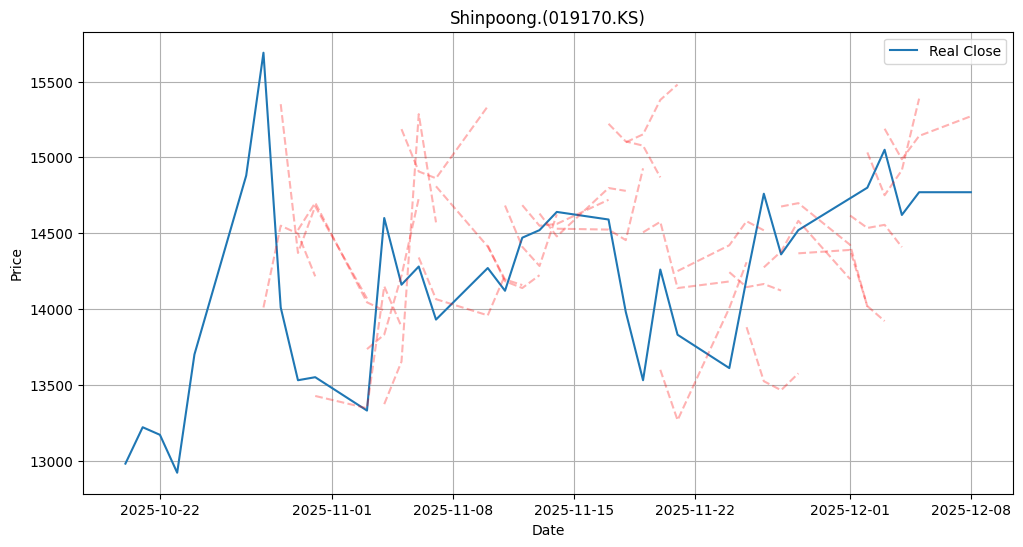

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


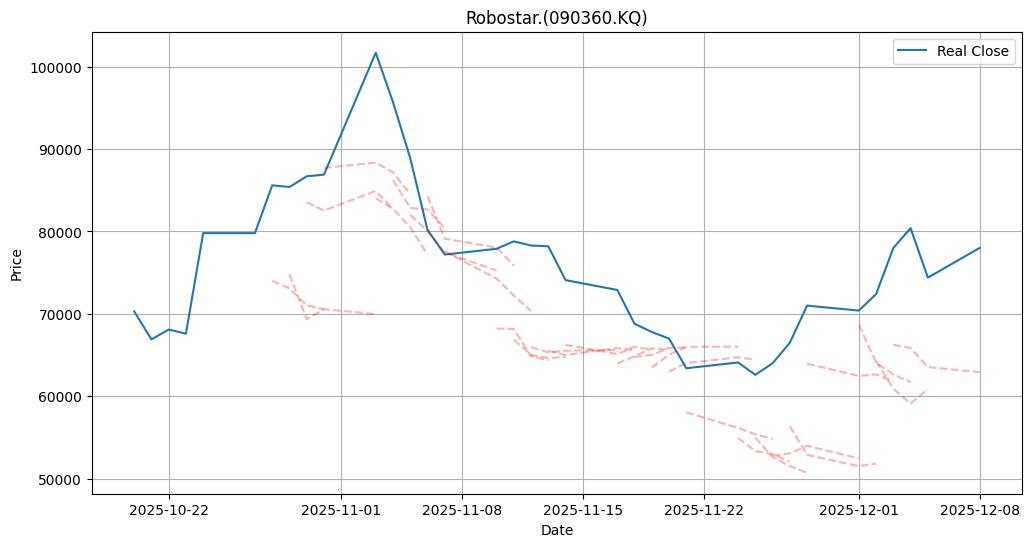

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


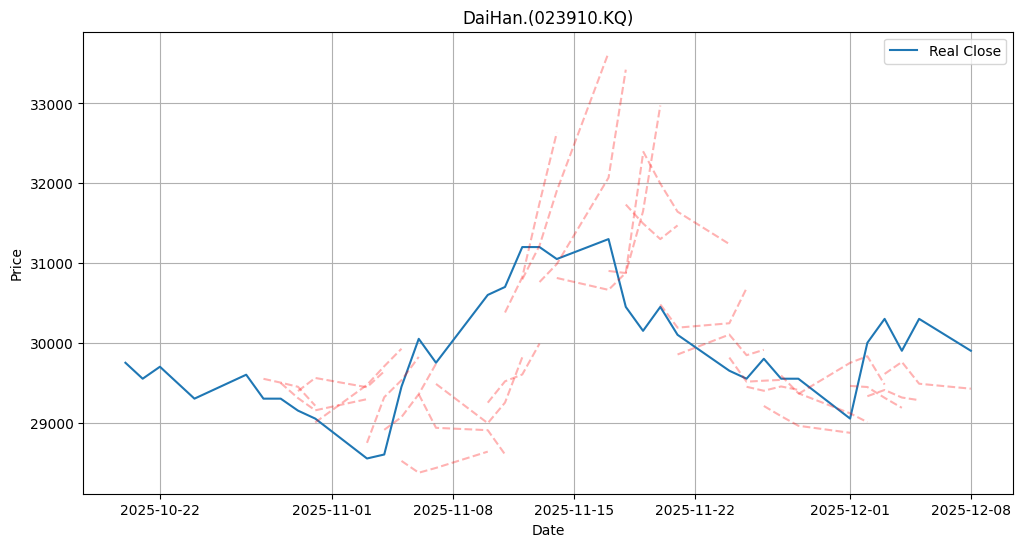

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


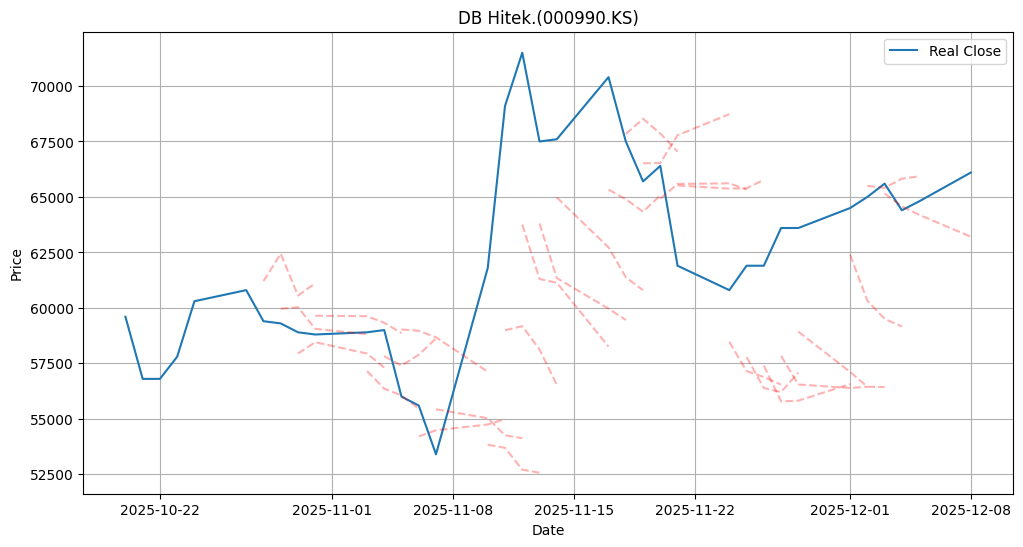

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


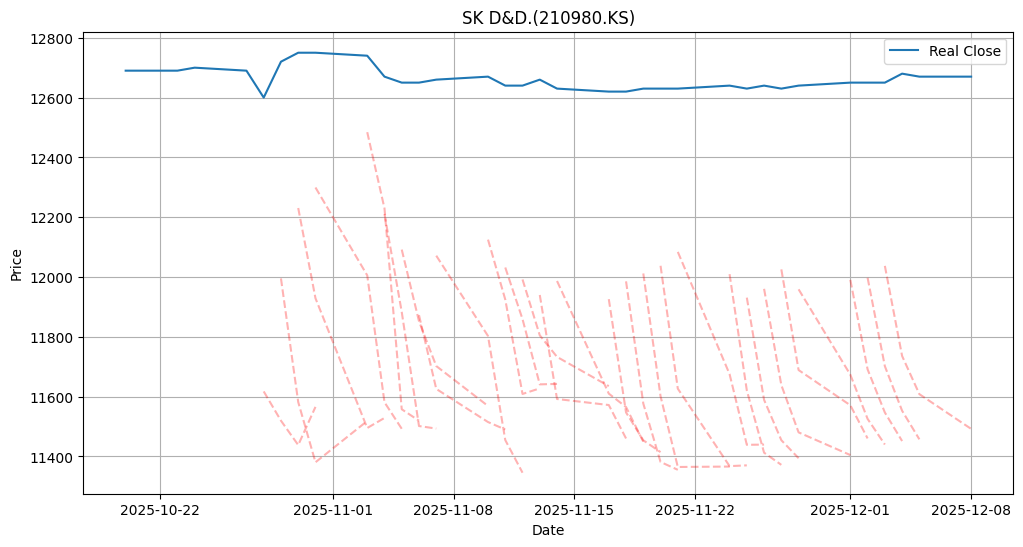

In [116]:
##4일 통으로 예측

import matplotlib.pyplot as plt
from keras.models import load_model

def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for i, idx in enumerate(feature_indices):
        y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
    return y

def denormalize_std(y_norm, mean_vals, std_vals, feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for idx in feature_indices:
        y[..., idx] = y[..., idx] * std_vals[idx] + mean_vals[idx]
    return y


def recursive_predict(
    model,
    x_start_norm,
    future_days=4,
    price_feat_idx=[0,1,2,3]
):
    preds = []
    x_cur = x_start_norm.copy()   # (lookback, features)

    for _ in range(future_days):
        y_pred_norm = model.predict(
            x_cur[np.newaxis, ...],
            verbose=0
        )
        next_day = y_pred_norm[0, 0]   # (4,)
        preds.append(next_day)

        # 입력 갱신 (shift + 예측값 삽입)
        x_next = x_cur.copy()
        x_next[:-1] = x_cur[1:]
        x_next[-1, price_feat_idx] = next_day
        x_cur = x_next

    return np.array(preds)   # (4, 4)

# =========================
# 모델 로드
# =========================
best_model = load_model("best_model.h5")

# minmax_vals = [
#     [sp_min, sp_max],
#     [rbs_min, rbs_max],
#     [dh_min, dh_max],
#     [dbh_min, dbh_max],
#     [skd_min, skd_max]
# ]

std_vals = [
    (sp_mean, sp_std),
    (rbs_mean, rbs_std),
    (dh_mean, dh_std),
    (dbh_mean, dbh_std),
    (skd_mean, skd_std)
]


titles = [
    "Shinpoong.(019170.KS)",
    "Robostar.(090360.KQ)",
    "DaiHan.(023910.KQ)",
    "DB Hitek.(000990.KS)",
    "SK D&D.(210980.KS)"
]

future_days = 4

# =========================
# 테스트 루프 (4일 통 예측)
# =========================
for i, data in enumerate(np_test_list_norm):
    test_data_norm = data.copy()
    x_test_norm, y_true_norm = [], []

    # future=4를 사용했으므로 range는 (data.shape[0] - lookback - future + 1) 로 변경
    for idx in range(data.shape[0] - lookback - future + 1):
        x_test_norm.append(data[idx:idx+lookback])
        y_true_norm.append(data[idx+lookback:idx+lookback+future,0:4])

    x_test_norm = np.array(x_test_norm)
    y_true_norm = np.array(y_true_norm)

    # 예측: 모델에 테스트 데이터를 한 번에 넣고 4일치 예측 결과를 얻음
    y_pred_norm = best_model.predict(x_test_norm)

    # ... (역정규화 코드 생략, 기존 코드의 mean/std 활용)
    mean_vals, std_vals_i = std_vals[i]

    test_data = test_data_norm.copy()
    test_data[:,0:4] = denormalize_std(
        test_data[:,0:4],
        mean_vals,
        std_vals_i
    )

    y_true = denormalize_std(y_true_norm, mean_vals, std_vals_i)
    y_pred = denormalize_std(y_pred_norm, mean_vals, std_vals_i)

    # =========================
    # Plot (4일 통 예측 결과 시각화)
    # =========================
    plt.figure(figsize=(12,6))
    dates_full = shinpoong_pharm_finance.index[shinpoong_test_idx]

    plt.plot(dates_full, test_data[:,0], label="Real Close")

    # 예측 결과를 실제 시점(dates_full)에 맞게 그리기
    for w in range(len(y_pred)):
        base_idx = w + lookback
        dates_w = dates_full[base_idx:base_idx+future]

        # y_pred[w, :, 0] 는 w 시점에서 예측한 미래 4일의 Close 가격
        plt.plot(
            dates_w,
            y_pred[w, :, 0],
            color='red',
            alpha=0.3,
            linestyle='--'
        )

    plt.title(titles[i])
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [117]:
#1일 예측만 하고 모델이 1일 shift한 것 처럼 나오고 있음 변경 사항으로  미래4일 예측 모델로 바꿔야 함 - 2025-12-04-01:34 AM